<a href="https://colab.research.google.com/github/Sunny20235195/stock-market-price-prediction/blob/main/stock_prediction_using_LSTM_with_GA_ver1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import random

In [12]:
# Step 1: Download data using yfinance
def download_stock_data(ticker, staperiod="10y", interval="1d"):
    data = yf.download(ticker, period="10y", interval="1d")
    return data


In [13]:
# Step 2: Prepare data
def create_dataset(data, window_size=60): # kích thước của sổ mặc định(nếu không truyền vào thì window_size=60)
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

In [14]:
# Step 3: Build LSTM model
def build_model(input_shape, units=50):
    model = Sequential()
    model.add(LSTM(units, return_sequences=False, input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

Chỗ này mới là 3 thế hệ và mỗi thế hệ 5 cá thể (hơi ít). AE nâng lên càng cao thì càng chính xác.

In [15]:
# Step 4: Genetic Algorithm for hyperparameter tuning
def genetic_algorithm(X_train, y_train, X_val, y_val, population_size=5, generations=3, mutation_rate=0.05, crossover_rate=0.9): # Các thông số trong GA
    # --------------------------
    # 1. Create a random individual
    def create_individual():
        return {
            'window_size': random.randint(30, 90), # Kích thước cửa sổ chọn từ 30 đến 90 ngày (có thể thay đổi)
            'units': random.choice([32, 64, 128]) # Số units trên 1 lớp LSTM. Chọn các số này là vì GPU, TPU tính toán hiệu quả hơn với các giá trị unit là bội của 32
        }

    # --------------------------
    # 2. Evaluate fitness (lower MSE is better)
    def fitness(ind):
        X_win, y_win = create_dataset(scaled_data, ind['window_size'])
        X_win, y_win = X_win[:-100], y_win[:-100]  # use training data # dùng phần đầu để train
        X_val_gen, y_val_gen = X_win[-100:], y_win[-100:] # dùng 100 dữ liệu cuối để test
        model = build_model((ind['window_size'], 1), units=ind['units']) # build model
        model.fit(X_win, y_win, epochs=3, batch_size=32, verbose=0) # huấn luyện mô hình
        preds = model.predict(X_val_gen) # dự đoán với dữ liệu test
        return mean_squared_error(y_val_gen, preds) # tính MSE (fitness định nghĩa ở đây thì cá thể có fitness càng nhỏ thì cá thể đó càng tốt)

    # --------------------------
    # 3. Selection: sort by fitness (elitism: top N)
    def selection(population, scores, num_elites=2):
        sorted_pop = [x for _, x in sorted(zip(scores, population))]
        return sorted_pop[:num_elites] # lấy trước 2 cá thể tốt nhất (fitness thấp nhất)

    # --------------------------
    # 4. Crossover: combine 2 parents into 1 child
    def crossover(parent1, parent2):
        if random.random() < crossover_rate: # nếu random ra < tỉ lệ lai ghép thì cho lai.
            return {
                'window_size': random.choice([parent1['window_size'], parent2['window_size']]),
                'units': random.choice([parent1['units'], parent2['units']])
            }
        else:
            # No crossover, just clone one of the parents(nếu ko thì ko làm gì)
            return random.choice([parent1, parent2]).copy()
    # --------------------------
    # 5. Mutation: randomly alter genes
    def mutate(ind):
        if random.random() < mutation_rate: # random ra nhỏ hơn tỉ lệ đột biến thì cho đột biến
            ind['window_size'] = random.randint(30, 90)
        if random.random() < mutation_rate:
            ind['units'] = random.choice([32, 64, 128])
        return ind

    # --------------------------
    # 6. Replacement: create new generation from elites + offspring
    def create_next_generation(elites, population, size, scores):
        next_gen = elites[:]
        sorted_pop = [x for _, x in sorted(zip(scores, population))]
        while len(next_gen) < size:
            parent1, parent2 = random.sample(sorted_pop[:4], 2) # chọn 4 cá thể tốt nhất xong chọn 2 bố mẹ. Rồi tiến hành lai ghép, đột biến nếu có.
            child = crossover(parent1, parent2)
            child = mutate(child)
            next_gen.append(child)
        return next_gen

    # --------------------------
    # 7. Repeat over generations
    population = [create_individual() for _ in range(population_size)]
    best_individual = None
    best_score = float('inf')

    for gen in range(generations):
        print(f"\n Generation {gen+1}")
        scores = [fitness(ind) for ind in population]
        for i, (ind, score) in enumerate(zip(population, scores)):
            print(f"Individual {i+1}: window_size={ind['window_size']}, units={ind['units']}, MSE={score:.6f}")

        elites = selection(population, scores, num_elites=2)
        best_elite = elites[0]
        best_elite_score = scores[population.index(best_elite)]  # lấy đúng fitness đã tính
        print(f"Best individual of generation {gen+1}: window_size={best_elite['window_size']}, units={best_elite['units']}, MSE={best_elite_score:.6f}")

        if best_elite_score < best_score: # lấy cá thể tốt nhất trong tất cả những lần lai ghép
            best_score = best_elite_score
            best_individual = best_elite.copy()

        population = create_next_generation(elites, population, population_size, scores) # tạo thế hệ mới

    print(f"\n Final best individual: window_size={best_individual['window_size']}, units={best_individual['units']}, MSE={best_score:.6f}")
    return best_individual

In [22]:
# Example usage
data = download_stock_data("AAPL")


[*********************100%***********************]  1 of 1 completed


In [24]:
# Đảm bảo dữ liệu là của các ngày liên tục ('D': daily),
# các ngày không có dữ liệu (T7,CN) thì giá trị dữ liệu được gán NaN
data = data.asfreq('D')

# Kiểm tra 10 dòng đầu để đảm bảo không sót ngày nào
data.tail(10)

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2025-05-14,212.330002,213.940002,210.580002,212.429993,49325800.0
2025-05-15,211.449997,212.960007,209.539993,210.949997,45029500.0
2025-05-16,211.259995,212.570007,209.770004,212.360001,54737900.0
2025-05-17,NaN,NaN,NaN,NaN,NaN
2025-05-18,NaN,NaN,NaN,NaN,NaN
2025-05-19,208.779999,209.479996,204.259995,207.910004,46140500.0
2025-05-20,206.860001,208.470001,205.029999,207.669998,42496600.0
2025-05-21,202.089996,207.039993,200.710007,205.169998,59211800.0


In [26]:
# fillna() là hàm dùng để ghi đè các ô có giá trị NaN
# method='ffill' (forward fill) nghĩa là: Nếu một ô có giá trị NaN,
# hãy lấy giá trị ở dòng phía trên nó để điền vào ()
data = data.fillna(method='ffill')

# Kiểm tra 10 dòng đầu để đảm bảo không còn giá trị NaN nào.
data.tail(10)

<ipython-input-26-2930b460f67b>:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2025-05-14,212.330002,213.940002,210.580002,212.429993,49325800.0
2025-05-15,211.449997,212.960007,209.539993,210.949997,45029500.0
2025-05-16,211.259995,212.570007,209.770004,212.360001,54737900.0
2025-05-17,211.259995,212.570007,209.770004,212.360001,54737900.0
2025-05-18,211.259995,212.570007,209.770004,212.360001,54737900.0
2025-05-19,208.779999,209.479996,204.259995,207.910004,46140500.0
2025-05-20,206.860001,208.470001,205.029999,207.669998,42496600.0
2025-05-21,202.089996,207.039993,200.710007,205.169998,59211800.0


In [27]:
# Lấy ra duy nhất cột giá đóng cửa (Close) –
# đây là dữ liệu quan trọng nhất trong phân tích tài chính và dự báo.
close_prices = data[['Close']]

# Kiểm tra 10 giá trị đầu của chuỗi Close, để đảm bảo dữ liệu được lọc đúng.
close_prices.tail(10)

Price,Close
Ticker,AAPL
Date,
2025-05-14,212.330002
2025-05-15,211.449997
2025-05-16,211.259995
2025-05-17,211.259995
2025-05-18,211.259995
2025-05-19,208.779999
2025-05-20,206.860001
2025-05-21,202.089996


In [28]:
scaler = MinMaxScaler() # chuẩn hóa dữ liệu
close_prices = data['Close'].values.reshape(-1, 1)
scaled_data = scaler.fit_transform(close_prices)


In [29]:
# Temporarily use fixed window for splitting
temp_window = 60
X_all, y_all = create_dataset(scaled_data, temp_window)
X_train, y_train = X_all[:-100], y_all[:-100]
X_val, y_val = X_all[-100:], y_all[-100:]

In [30]:
# GA optimization
best_params = genetic_algorithm(X_train, y_train, X_val, y_val)
print("Best Parameters from GA:", best_params)


 Generation 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Individual 1: window_size=48, units=32, MSE=0.001135
Individual 2: window_size=59, units=50, MSE=0.000972
Individual 3: window_size=85, units=128, MSE=0.000474
Individual 4: window_size=63, units=64, MSE=0.000748
Individual 5: window_size=75, units=50, MSE=0.000560
Best individual of generation 1: window_size=85, units=128, MSE=0.000474

 Generation 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Individual 1: window_size=85, units=128, MSE=0.000452
Individual 2: window_size=75, units=50, MSE=0.000726
Individual 3: window_size=59, units=50, MSE=0.000561
Individual 4: window_size=63, units=50, MSE=0.000725
Individual 5: window_size=63, units=64, MSE=0.000719
Best individual of generation 2: window_size=85, units=128, MSE=0.000452

 Generation 3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Individual 1: window_size=85, units=128, MSE=0.000533
Individual 2: window_size=59, units=50, MSE=0.000850
Individual 3: window_size=63, units=64, MSE=0.000672
Individual 4: window_size=63, units=50, MSE=0.000725
Individual 5: window_size=85, units=128, MSE=0.000563
Best individual of generation 3: window_size=85, units=128, MSE=0.000533

 Final best individual: window_size=85, units=128, MSE=0.000452
Best Parameters from GA: {'window_size': 85, 'units': 128}


In [31]:
# Final model training and evaluation
X_final, y_final = create_dataset(scaled_data, best_params['window_size'])
split_index = int(len(X_final) * 0.8) # chia tập train - test là 80 - 20
X_train_final, y_train_final = X_final[:split_index], y_final[:split_index]
X_test, y_test = X_final[split_index:], y_final[split_index:]


model = build_model((best_params['window_size'], 1), best_params['units'])
model.fit(X_train_final, y_train_final, epochs=10, batch_size=32, verbose=1)
preds = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("Test RMSE:", rmse)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.0128
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - loss: 1.4052e-04
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - loss: 1.3785e-04
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - loss: 1.2575e-04
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - loss: 1.2801e-04
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - loss: 1.2375e-04
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 91ms/step - loss: 1.1977e-04
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - loss: 1.1241e-04
Epoch 9/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - loss: 1.0702e-04
Epoch 10/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - loss: 1.0297e-04
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
Test RMSE: 0.0204536142146597


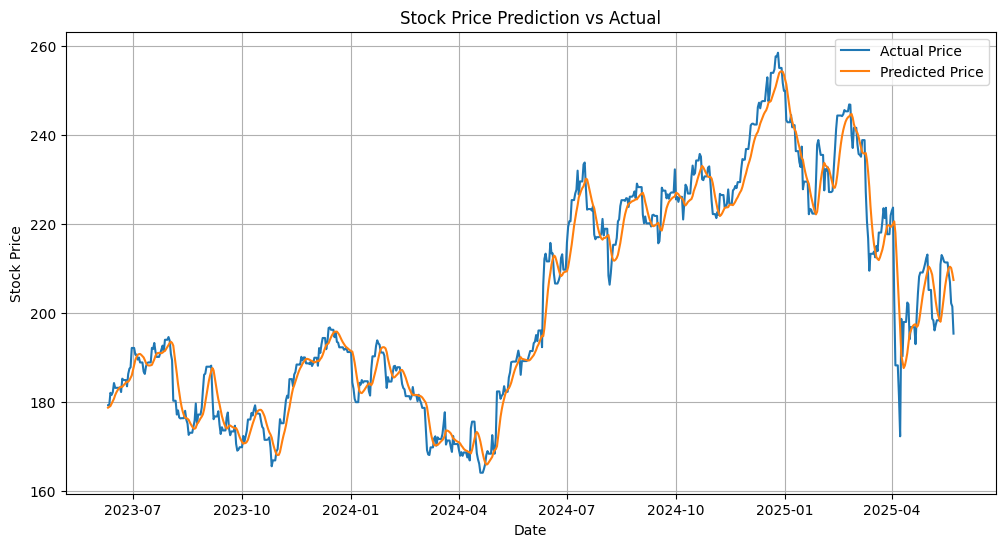

In [32]:
# Plot predictions vs actual
y_test_rescaled = scaler.inverse_transform(y_test)
preds_rescaled = scaler.inverse_transform(preds)
# Get the corresponding dates for the last 100 entries (the test set)
dates = data.index[-len(y_test):]  # data is the original DataFrame from yfinance
plt.figure(figsize=(12, 6))
plt.plot(dates, y_test_rescaled, label='Actual Price')
plt.plot(dates, preds_rescaled, label='Predicted Price')
plt.title('Stock Price Prediction vs Actual')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()


Thêm vòng for để chạy từng mã cổ phiếu. AE test hiệu năng ở phần trên đã thấy oke thì mới chạy cái này nhé. Thời gian chạy x loại cổ phiếu bằng x lần thời gian chạy 1 cổ phiếu :((

In [ ]:
symbols = ["AAPL", "GOOG", "MSFT", "AMZN"]

In [ ]:
for symbol in symbols:
    print(f"\n========= Processing {symbol} =========")

    # code này y như phần trên
    data = download_stock_data(symbol)
    data = data.asfreq('D')
    data = data.fillna(method='ffill')
    scaler = MinMaxScaler()
    close_prices = data['Close'].values.reshape(-1, 1)
    scaled_data = scaler.fit_transform(close_prices)

    temp_window = 60
    X_all, y_all = create_dataset(scaled_data, temp_window)
    X_train, y_train = X_all[:-100], y_all[:-100]
    X_val, y_val = X_all[-100:], y_all[-100:]

    best_params = genetic_algorithm(X_train, y_train, X_val, y_val)
    print("Best Parameters from GA:", best_params)

    X_final, y_final = create_dataset(scaled_data, best_params['window_size'])
    split_index = int(len(X_final) * 0.8)
    X_train_final, y_train_final = X_final[:split_index], y_final[:split_index]
    X_test, y_test = X_final[split_index:], y_final[split_index:]

    model = build_model((best_params['window_size'], 1), best_params['units'])
    model.fit(X_train_final, y_train_final, epochs=10, batch_size=32, verbose=1)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    print("Test RMSE:", rmse)

    y_test_rescaled = scaler.inverse_transform(y_test)
    preds_rescaled = scaler.inverse_transform(preds)
    dates = data.index[-len(y_test):]

    plt.figure(figsize=(12, 6))
    plt.plot(dates, y_test_rescaled, label='Actual Price')
    plt.plot(dates, preds_rescaled, label='Predicted Price')
    plt.title(f'{symbol} Stock Price Prediction vs Actual')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid(True)
    plt.show()
